In [1]:
using DataFrames, CSV, Plots,Statistics, StatsPlots, Distributions, StatsBase, StatsModels, HypothesisTests, LinearAlgebra, StateSpaceModels

In [2]:
df = CSV.read("AuQuGDP.csv", DataFrame);

In [3]:
names(df)

5-element Vector{String}:
 "Time"
 "AuGDP"
 "quarter"
 "year"
 "t"

In [4]:
first(df, 4)

,Time,AuGDP,quarter,year,t
,String15,Float64,Int64,Int64,String7
1,01jan1960,6.4683e10,1,1960,1960q1
2,01apr1960,6.6473e10,2,1960,1960q2
3,01jul1960,6.6623e10,3,1960,1960q3
4,01oct1960,6.649e10,4,1960,1960q4


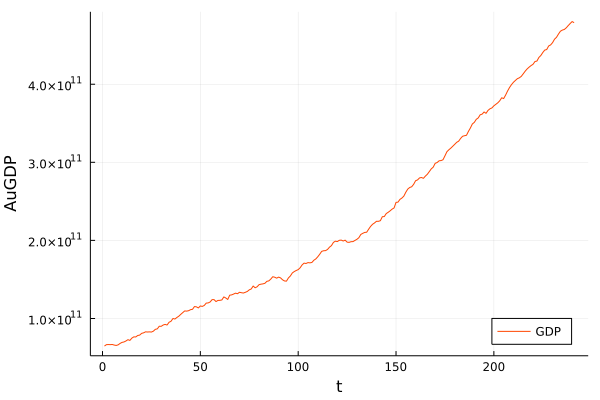

In [5]:
plot(xlabel="t", ylabel="AuGDP", legend=:bottomright)
plot!(df.AuGDP, color="orangered", label="GDP")

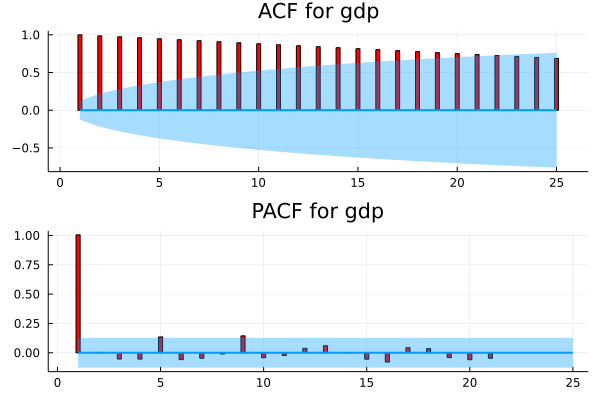

In [44]:
acf_gdp  = autocor(df.AuGDP);
acf2_gdp = acf_gdp.^2;
pacf_gdp = pacf(df.AuGDP,[1:1:21;]);

se_acf_gdp = []

for i in [1:size(acf_gdp)[1];]  
    push!(se_acf_gdp, sqrt((1+2*sum(acf2_gdp[1:i-1]))/size(df)[1]));   
end

ub_acf_gdp = se_acf_gdp * quantile(TDist(size(df)[1]-1), 0.975);
lb_acf_gdp = se_acf_gdp * quantile(TDist(size(df)[1]-1), 0.025);

ub_pacf_gdp = quantile(TDist(size(df)[1]-1), 0.975) / sqrt(size(df)[1]);
lb_pacf_gdp = quantile(TDist(size(df)[1]-1), 0.025) / sqrt(size(df)[1]);

p1 = bar(acf_gdp, title = "ACF for gdp", c = "red", legend = :topright, bar_width = 0.2)
p1 = plot!(zeros(size(acf_gdp)[1]), ribbon = (ub_acf_gdp .- lb_acf_gdp)./2 , fillalpha = 0.35, c = 1, lw = 2)

p2 = bar(pacf_gdp, title = "PACF for gdp", c = "red", legend = false, bar_width = 0.2)
p2 = plot!(zeros(size(acf_gdp)[1]), ribbon = (ub_pacf_gdp .- lb_pacf_gdp)./2 , fillalpha = 0.35, c = 1, lw = 2)

plot(p1, p2, layout = (2, 1), legend = false)

# ADF test for  GDP

In [6]:
s = df.AuGDP

ADFTest(s, Symbol("trend"), 3)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -0.00187636

Test summary:
    outcome with 95% confidence: fail to reject h_0
    p-value:                     0.9855

Details:
    sample size in regression:          237
    number of lags:                     3
    ADF statistic:                      -0.443589
    Critical values at 1%, 5%, and 10%: [-3.99683 -3.42887 -3.13785]


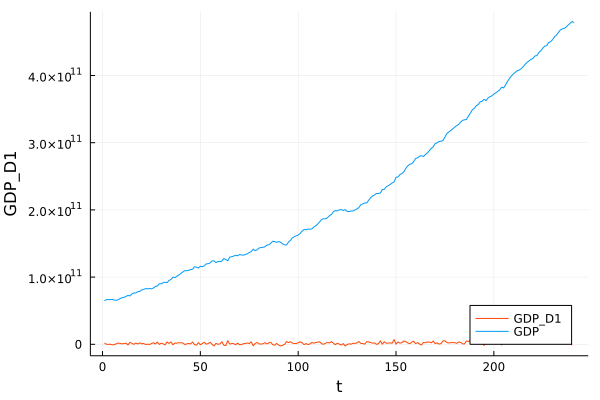

In [7]:
s_diff = diff(s)

plot(xlabel="t", ylabel="GDP_D1", legend=:bottomright)
plot!(s_diff, color="orangered", label="GDP_D1")
plot!(s, color=1, label="GDP")

In [41]:
size(acf_gdpD1)[1]

25

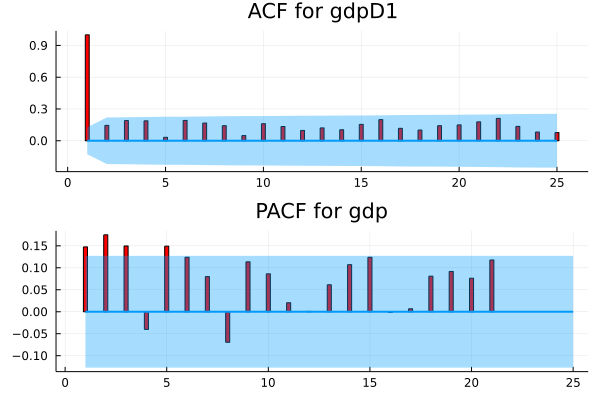

In [43]:
acf_gdpD1  = autocor(s_diff);
acf2_gdpD1 = acf_gdpD1.^2;
pacf_gdpD1 = pacf(s_diff,[1:1:21;]);

se_acf_gdpD1 = []

for i in [1:size(acf_gdpD1)[1];]  
    push!(se_acf_gdpD1, sqrt((1+2*sum(acf2_gdpD1[1:i-1]))/size(s_diff)[1]));   
end

ub_acf_gdpD1 = se_acf_gdpD1 * quantile(TDist(size(s_diff)[1]-1), 0.975);
lb_acf_gdpD1 = se_acf_gdpD1 * quantile(TDist(size(s_diff)[1]-1), 0.025);

ub_pacf_gdpD1 = quantile(TDist(size(s_diff)[1]-1), 0.975) / sqrt(size(s_diff)[1]);
lb_pacf_gdpD1 = quantile(TDist(size(s_diff)[1]-1), 0.025) / sqrt(size(s_diff)[1]);

p1 = bar(acf_gdpD1, title = "ACF for gdpD1", c = "red", legend = :topright, bar_width = 0.2)
p1 = plot!(zeros(size(acf_gdpD1)[1]), ribbon = (ub_acf_gdpD1 .- lb_acf_gdpD1)./2 , fillalpha = 0.35, c = 1, lw = 2)

p2 = bar(pacf_gdpD1, title = "PACF for gdp", c = "red", legend = false, bar_width = 0.2)
p2 = plot!(zeros(size(acf_gdpD1)[1]), ribbon = (ub_pacf_gdpD1 .- lb_pacf_gdpD1)./2 , fillalpha = 0.35, c = 1, lw = 2)

plot(p1, p2, layout = (2, 1), legend = false)

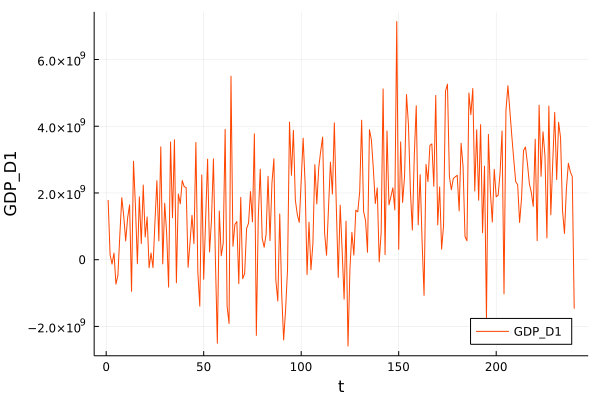

In [8]:
plot(xlabel="t", ylabel="GDP_D1", legend=:bottomright)
plot!(s_diff, color="orangered", label="GDP_D1")

# ADF test for first-order differenced GDP

In [10]:
ADFTest(s_diff, Symbol("trend"), 3)

Augmented Dickey-Fuller unit root test
--------------------------------------
Population details:
    parameter of interest:   coefficient on lagged non-differenced variable
    value under h_0:         0
    point estimate:          -1.03424

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-10

Details:
    sample size in regression:          236
    number of lags:                     3
    ADF statistic:                      -8.02704
    Critical values at 1%, 5%, and 10%: [-3.99699 -3.42894 -3.13789]


# AR(5)

In [49]:
data = s_diff[1:235];

model_sarima = SARIMA(data; order = (5, 0, 0), seasonal_order = (0, 0, 0, 0))
StateSpaceModels.fit!(model_sarima)

forec_sarima4 = forecast(model_sarima, 4)

StateSpaceModels.Forecast{Float64}([[1.864018013377485e9], [1.8375247284750724e9], [1.774077884928632e9], [1.481505221141256e9]], [[2.989558700388021e18], [3.0989311234860595e18], [3.2940503512032645e18], [3.564272424421342e18]])

In [46]:
model_sarima

"SARIMA"

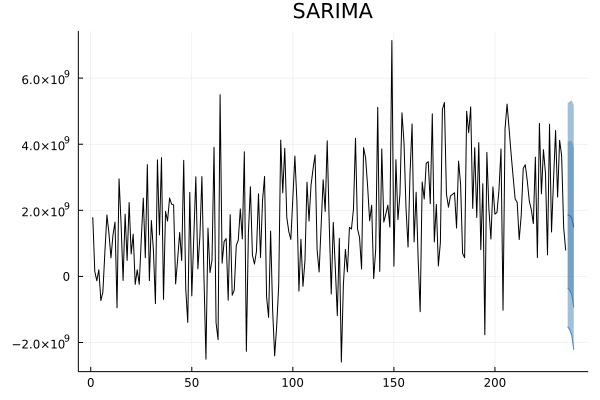

In [30]:
plot(model_sarima, forec_sarima4; title = "SARIMA", label = "")

In [32]:
forec_sarima1 = forecast(model_sarima, 1)

StateSpaceModels.Forecast{Float64}([[1.864018013377485e9]], [[2.989558700388021e18]])

# MA(6)

In [34]:
data = s_diff[1:235];

model_sarima = SARIMA(data; order = (0, 0, 6), seasonal_order = (0, 0, 0, 0))
StateSpaceModels.fit!(model_sarima);

forec_sarima4 = forecast(model_sarima, 4)

StateSpaceModels.Forecast{Float64}([[9.558689048909702e8], [2.317666239738993e8], [1.789306211976903e8], [3.0352522516858697e7]], [[2.989563930506114e18], [3.1879593560122163e18], [3.5530094251527404e18], [3.9579064560815447e18]])

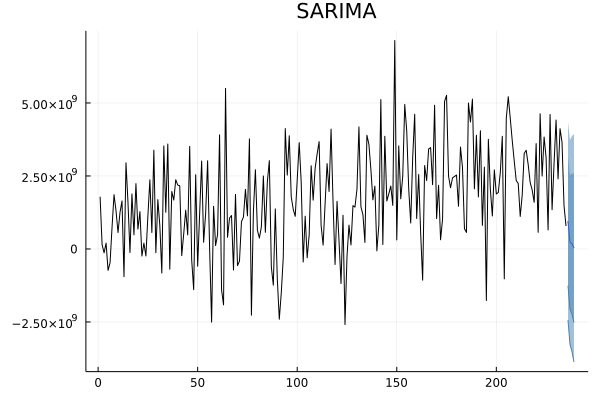

In [35]:
plot(model_sarima, forec_sarima4; title = "SARIMA", label = "")

In [36]:
forec_sarima1 = forecast(model_sarima, 1)

StateSpaceModels.Forecast{Float64}([[9.558689048909702e8]], [[2.989563930506114e18]])